# Modelling

In this notebook we will finally start working on getting a model to predict who may win in a game of chess given our variables. 

## Loading the data and libraries

In [1]:
#basic/typical packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from itertools import combinations

#sklearn packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import validation_curve
from sklearn.metrics import f1_score, log_loss, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
# https://datascience.stackexchange.com/questions/8064/how-to-use-cohens-kappa-as-the-evaluation-metric-in-gridsearchcv-in-scikit-lear
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score

In [2]:
train = pd.read_pickle('train_df.pkl')
test = pd.read_pickle('test_df.pkl')

In [3]:
train.head()

,rated,victory_status_mate,victory_status_outoftime,victory_status_resign,turns,white_rating,black_rating,opening_ply,time_allotted,increment,...,Counts_name_zinnowitz variation,Counts_name_zukertort,Counts_name_zukertort gambit,Counts_name_zukertort opening,Counts_name_zukertort system,Counts_name_zukertort variation,Counts_name_zurich,Counts_name_zurich gambit,Counts_name_zurich variation,winner_label
2858,0,1,0,0,0.163828,-0.976846,-0.378900,-0.648908,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0
7948,1,0,0,1,0.790929,2.243676,1.463170,1.852692,-0.397451,0.351493,...,0,0,0,0,0,0,0,0,0,2
15696,1,0,0,1,1.298583,-0.218264,-0.113780,-0.291536,-0.280300,-0.010609,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,-1.538306,-0.635484,1.783380,0.065835,0.071153,1.799901,...,0,0,0,0,0,0,0,0,0,0
14894,1,0,0,1,0.343000,-0.011379,0.020502,0.065835,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0


Recall that the winner_label is the target variable, and values of 0 indicates that the players who chose black won, 1 indicates a draw, and 2 indicates that players who chose white won.

In [4]:
y = train['winner_label']
X = train.drop(columns = 'winner_label')

In [5]:
X.head()

,rated,victory_status_mate,victory_status_outoftime,victory_status_resign,turns,white_rating,black_rating,opening_ply,time_allotted,increment,...,Counts_name_zinnowitz,Counts_name_zinnowitz variation,Counts_name_zukertort,Counts_name_zukertort gambit,Counts_name_zukertort opening,Counts_name_zukertort system,Counts_name_zukertort variation,Counts_name_zurich,Counts_name_zurich gambit,Counts_name_zurich variation
2858,0,1,0,0,0.163828,-0.976846,-0.378900,-0.648908,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0
7948,1,0,0,1,0.790929,2.243676,1.463170,1.852692,-0.397451,0.351493,...,0,0,0,0,0,0,0,0,0,0
15696,1,0,0,1,1.298583,-0.218264,-0.113780,-0.291536,-0.280300,-0.010609,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,-1.538306,-0.635484,1.783380,0.065835,0.071153,1.799901,...,0,0,0,0,0,0,0,0,0,0
14894,1,0,0,1,0.343000,-0.011379,0.020502,0.065835,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_test = test['winner_label']
X_test = test.drop(columns = 'winner_label')

Let's try a few different models, and compare later to pick the best one.

## Logistic Regression

Let's first get some basic accuracy scores with the default hyperparameters to quickly see how this model does initially. 

In [25]:
#note when using the default solver='lbfgs', we get an error about str not being able to decode, 
#it seems like it is related to the victory status columns datatypes
#in any case, the solvers: 'newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’, all are for multiclass classification problems
#we will just try newton-cg here and then the rest later in grid search
lr = LogisticRegression(solver='newton-cg', random_state=42, n_jobs=-1)

lr.fit(X, y)

LogisticRegression(n_jobs=-1, random_state=42, solver='newton-cg')

In [26]:
#let's just check the training score quickly
print('Accuracy training set score of logistic regression with default values:', lr.score(X, y))

Accuracy training set score of logistic regression with default values: 0.8442165480675318


In [27]:
#test score
print('Accuracy testing set score of logistic regression with default values:', lr.score(X_test, y_test))

Accuracy testing set score of logistic regression with default values: 0.7472274534421427


So these scores are pretty good already, but accuracy is hardly ever the best score. We will do Grid Search for hyperparameter tuning, but first let's establish our main metric.

We will use the kappa score as our main metric. The kappa score in general tells you how similar two raters are, but in the case of classification, like this problem, it will essentially rate how similar our predictions and actual values are. It is good to use in classification tasks with imbalanced data, which we have here since the number of draws lags behind the black and white winner labels.

A quote from the link, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900052/#:~:text=Cohen%20suggested%20the%20Kappa%20result,1.00%20as%20almost%20perfect%20agreement, gives us some guideline on what good values of kappa are: "Cohen suggested the Kappa result be interpreted as follows: values ≤ 0 as indicating no agreement and 0.01–0.20 as none to slight, 0.21–0.40 as fair, 0.41– 0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1.00 as almost perfect agreement." Thus, any kappa score above 0.6 is good, but ideally above 0.8 is what we will be aiming for. 

In [28]:
print('Kappa training set score of logistic regression with default values:', cohen_kappa_score(lr.predict(X), y))

y_pred = lr.predict(X_test)

print('Kappa testing set score of logistic regression with default values:',cohen_kappa_score(y_pred, y_test))

Kappa training set score of logistic regression with default values: 0.712750074536601
Kappa testing set score of logistic regression with default values: 0.5315338913834929


To briefly explain how kappa works, the kappa score is calculated by the following equation:

$$ \frac{p_0 - p_e}{1-p_e}, $$

where $p_0$ is simply the accuracy of the model, and $p_e$ is the measure of the agreement between the model predictions and the actual class values as if happening by chance. For more info on this, see: https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c.



The kappa score is not an option in the scoring parameter in gridsearch, so we must use make_scorer to make it an option.

In [7]:
kappa_scorer = make_scorer(cohen_kappa_score)

Now, let's do gridsearch with the kappa score as our custom metric.

Edit: unfortunately, all multiclass solvers (except newton-cg) caused some errors and increased run time too much, so only newton-cg was used here. Although, from a few singular trial and error runs it did seem like this was the best solver anyways, at least in terms of the accuracy metric.

In [29]:
#not all solvers support the l1 penalty, so we won't try it and just leave the default value to keep run time low
parameters = {'solver': ['newton-cg'], 
              'max_iter': [25, 50, 100, 125]}

lr = LogisticRegression(random_state=42)

clf = GridSearchCV(lr, parameters, scoring=kappa_scorer, n_jobs=-1)

clf.fit(X, y)

C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'max_iter': [25, 50, 100, 125],
                         'solver': ['newton-cg']},
             scoring=make_scorer(cohen_kappa_score))

In [30]:
print('Kappa training set score of logistic regression after gridsearch:', clf.score(X, y))
print('Kappa testing set score of logistic regression after gridsearch:', clf.score(X_test, y_test))

Kappa training set score of logistic regression after gridsearch: 0.712750074536601
Kappa testing set score of logistic regression after gridsearch: 0.5315338913834929


In [31]:
clf.best_params_

{'max_iter': 25, 'solver': 'newton-cg'}

So thanks to grid search we have the best parameters here, and it seems like the accuracy's didn't change at all. Adding a range for the C parameter wasn't done here because initially when tried it increased run times too much. Also, since it is the only other parameter of interest, we can look at it seperately with a validation curve. Before we do though, the next cell contains a function to plot the validation curve, which will be used repeatedly.

In [8]:
#function that plots a score against parameter values, to allow us to visualize how a certain parameter affects the score
def plot_train_val_scores(model, param_name, param_range, logplot = False, scoring_metric=kappa_scorer, y_label='kappa score'):
    #using the validation_curve function to get the score values
    train_scores, valid_scores = validation_curve(model, X, y, 
                                                  param_name=param_name, 
                                                  param_range=param_range, 
                                                  cv=5,
                                                  scoring=kappa_scorer, 
                                                  n_jobs=-1)
    
    #take the mean of the cross validation scores and plot these
    train_scores_mean = train_scores.mean(axis=1)
    valid_scores_mean = valid_scores.mean(axis=1)
    
    #if the var_smoothing parameter ranges increase exponentially, we need to take the log of it to get a better visual
    if logplot:
        plt.semilogx(param_range, train_scores_mean, label="Training score")
        plt.semilogx(param_range, valid_scores_mean, label="Validation score")
    else:
        plt.plot(param_range, train_scores_mean, label="Training score")
        plt.plot(param_range, valid_scores_mean, label="Validation score")
    
    plt.title('Training and validation scores for {} parameter values'.format(param_name))
    plt.xlabel('parameter range')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

Now we can use this function by just filling in the model, parameter name, and parameter range.

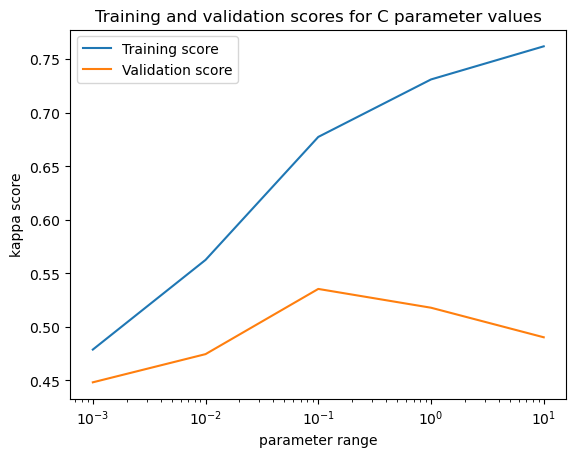

In [66]:
model = LogisticRegression(solver = 'newton-cg', random_state=42, max_iter=25)

param_range = [0.001, 0.01, 0.1, 1, 10]

plot_train_val_scores(model, 'C', param_range, logplot = True)

So from this curve it seems like the best value for C is 0.1. After this value the training score increasing and validation score decreases, indicating overfitting.

### Evaluation Metrics for Logistic Regression

Now that the best model and its best hyperparameters are found, let's look at some evaluation metrics to compare to other models.

In [7]:
#so here is the best model we found
log_reg = LogisticRegression(solver = 'newton-cg', random_state=42, max_iter=25, C=0.1)

log_reg.fit(X, y)

LogisticRegression(C=0.1, max_iter=25, random_state=42, solver='newton-cg')

In [8]:
# for comparison table later
log_reg_best_params = log_reg.get_params()

**Let's get the training and testing accuracies.**

Despite the kappa score being our main metric, we will still report the accuracy scores here. It just might be usefull to see on its own, since it is used to calculate the kappa score.

In [9]:
log_reg_training_score = log_reg.score(X, y)

log_reg_testing_score = log_reg.score(X_test, y_test)

print('Logistic Regression training score:', log_reg_training_score)
print('Logistic Regression testing score:', log_reg_testing_score)

Logistic Regression training score: 0.8191712013394726
Logistic Regression testing score: 0.7620841180163214


**Let's get the kappa scores.**

In [10]:
log_reg_training_kappa = cohen_kappa_score(log_reg.predict(X), y)

y_pred = log_reg.predict(X_test)

log_reg_testing_kappa = cohen_kappa_score(y_pred, y_test)

print('Logistic Regression kappa training score:', log_reg_training_kappa)
print('Logistic Regression kappa testing score:', log_reg_testing_kappa)

Logistic Regression kappa training score: 0.6662933838842291
Logistic Regression kappa testing score: 0.557663072027829


So you can see here with the optimal C value, the training score went down just a bit, and the validation score went up just a bit. This is good, but only mildly significant really.

**Let's get the F1 scores.**

The F1 score can also be a useful metric in multiclass imbalanced dataset problems. We will report it here just in case it shows something significant or odd, like a model has a much better kappa score than another one, but the opposite for their respective F1 scores.

In [11]:
f1_weighted_lr = f1_score(y_test, y_pred, average='weighted')

print('The weighted F1 score for logistic regression is:', f1_weighted_lr)

The weighted F1 score for logistic regression is: 0.7623435145691216


Now let's get a visual representation of how th model is doing with a confusion matrix.

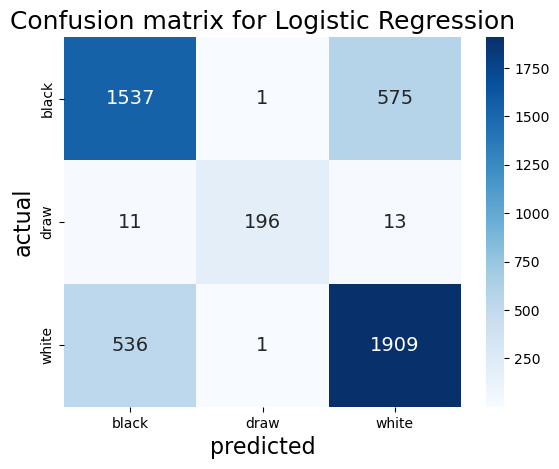

In [29]:
#now let's get the confusion matrix to see how it does
con_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["black", "draw", "white"], yticklabels = ["black", "draw", "white"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for Logistic Regression', fontsize=18)
plt.show()

This model's predictions doesn't seem too bad here. The kappa testing score was not above 0.6, being that it was about 0.56, but still it is close. Let's take another look visually via ROC curves.

**We can also get ROC curves.**

To do this, we are borrowing code from this link: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html.

Essentially, what we are doing here is getting ROC curves that compares each target label to other target labels individually. So, for example, if we are comparing predicting white winners or a draw, then the ROC curve will treat both of them as the positive case, and plot both of those ROC curves. It will then also plot an average of the two ROC curves. Doing this for other combinations will net us three different plots. 

We can easily repeat this for the other models as well, especially by putting this code into a function for repeated use, which is done in the next cell.

In [39]:
# the y_score name comes from orginal code from the link above, but it is simply the predicted probabilities, 
# which probably means to apply the predict_proba method on the classifier of interest.
def roc_curves(y_score):
    #these are just some things we need for the borrowed code to work - easier to define them seperatly here

    #this gives use the target labels as pairs, to do one vs one ROC curves
    pair_list = list(combinations(np.unique(y), 2))

    #just grid space
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    
    #we need the actual target names, instead of just the numbers. Recall 0 is black, 1 is draw, and 2 is white
    target_names = np.array(['black', 'draw', 'white'])

    #this just gets what classes we have. You can double check by running: label_binarizer.classes_
    label_binarizer = LabelBinarizer().fit(y)
    
    pair_scores = []
    mean_tpr = dict()

    for ix, (label_a, label_b) in enumerate(pair_list):

        a_mask = y_test == label_a
        b_mask = y_test == label_b
        ab_mask = np.logical_or(a_mask, b_mask)

        a_true = a_mask[ab_mask]
        b_true = b_mask[ab_mask]

        idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
        idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

        fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
        fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

        mean_tpr[ix] = np.zeros_like(fpr_grid)
        mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
        mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
        mean_tpr[ix] /= 2
        mean_score = auc(fpr_grid, mean_tpr[ix])
        pair_scores.append(mean_score)

        #modifying code to work with the labels in this dataset - just renaming from number to categries
        cat1 = {0:'black', 1:'draw', 2:'white'}[label_a]
        cat2 = {0:'black', 1:'draw', 2:'white'}[label_b]

        fig, ax = plt.subplots(figsize=(6, 6))
        plt.plot(
            fpr_grid,
            mean_tpr[ix],
            label=f"Mean {cat1} vs {cat2} (AUC = {mean_score :.2f})",
            linestyle=":",
            linewidth=4,
        )
        RocCurveDisplay.from_predictions(
            a_true,
            y_score[ab_mask, idx_a],
            ax=ax,
            name=f"{cat1} as positive class",
        )
        RocCurveDisplay.from_predictions(
            b_true,
            y_score[ab_mask, idx_b],
            ax=ax,
            name=f"{cat2} as positive class",
        )
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")




        plt.title(f"{target_names[idx_a]} vs {cat2} ROC curves")
        plt.legend()
        plt.show()

    one_v_one_auc = np.average(pair_scores)
    print(f"Macro-averaged One-vs-One ROC AUC score:\n{one_v_one_auc:.2f}")

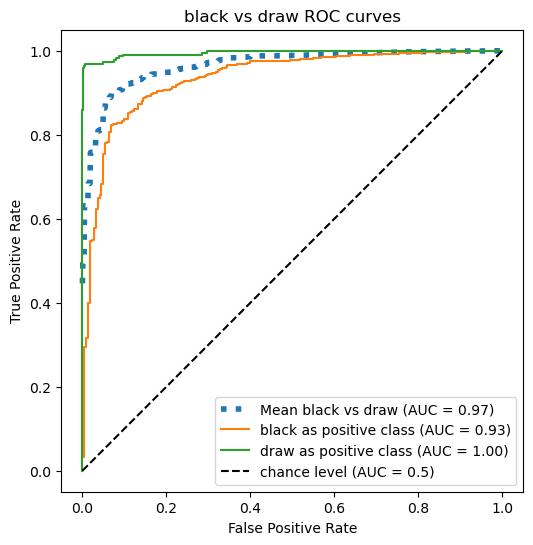

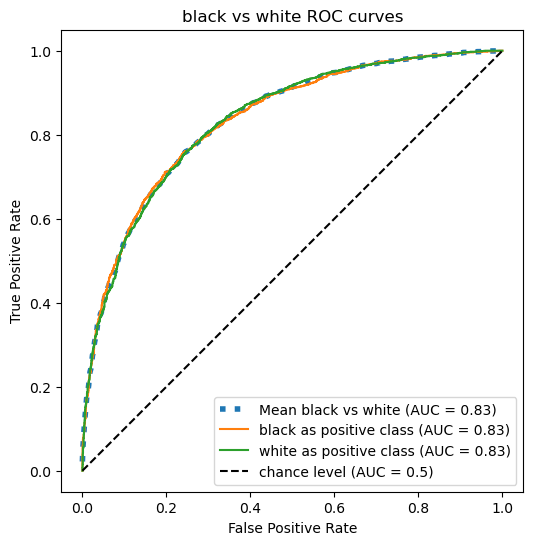

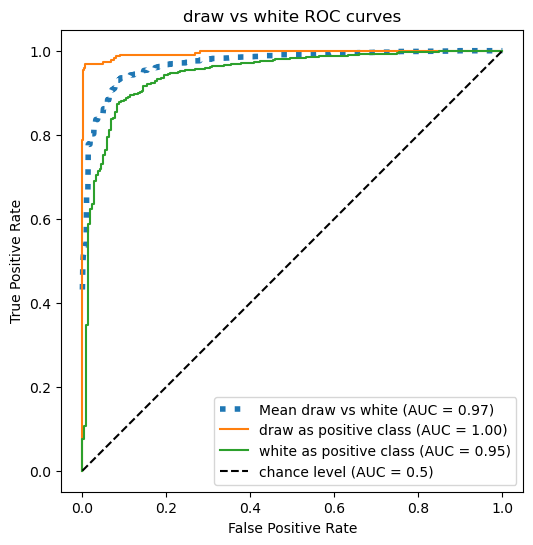

Macro-averaged One-vs-One ROC AUC score:
0.92


In [40]:
y_pred_proba = log_reg.predict_proba(X_test)

roc_curves(y_pred_proba)

**Some observations about the ROC AUC plots:** When you look at the ROC curves where draw is the positive class, the AUC score is almost 1. This is in line with the confusion matrix above, since the model predicts draws quite well. Then, when black or white are the positive class, and we are comparing them to the draw label, the AUC score goes down. Again, this makes sense since from the confusion matrix does have a noticeable error rate when predicting black or white, though it is not high. 

Then when you look at black vs white ROC curve, you can see all AUC scores and ROC curves are the same. This is certainly in line with the confusion matrix above as well, since when the model falsely predicts black or white, it usually is because it predicted the opposite winner, and not a draw. In any case, when you average all these AUC scores, it is 0.92 which is pretty good.

## Random Forest

Again let's quickly try the default values here for random forest.

In [53]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf.fit(X, y)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [54]:
print('Random Forest training accuracy with default values:', rf.score(X, y))
print('Random Forest testing accuracy with default values:', rf.score(X_test, y_test))

Random Forest training accuracy with default values: 1.0
Random Forest testing accuracy with default values: 0.7170956267001465


In [56]:
print('Random forest kappa training score with default values:', cohen_kappa_score(rf.predict(X), y))
print('Random forest kappa testing score with default values:', cohen_kappa_score(rf.predict(X_test), y_test))

Random forest kappa training score with default values: 1.0
Random forest kappa testing score with default values: 0.4564123816876855


Random forest overfits on the training data here, so default values will definitely not be kept. Let's move onto Grid Search now. Note we are trying different class weights here since the data is imbalanced. It should be expected that None will not be the best option.

In [43]:
parameters = {'n_estimators': [50, 100, 150], 
              'max_depth': [5, 7, 9], 
              'min_samples_split': [1, 3, 5], 
              'min_samples_leaf':[1, 3],
              'class_weight': ['balanced', 'balanced_subsample', None]
             }

rf = RandomForestClassifier(random_state=42)

clf = GridSearchCV(rf, parameters, scoring=kappa_scorer, n_jobs=-1)

clf.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'max_depth': [5, 7, 9], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [1, 3, 5],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(cohen_kappa_score))

In [44]:
print('Random Forest kappa training score after gridsearch is:', clf.score(X, y))
print('Random Forest kappa testing score after gridsearch is:', clf.score(X_test, y_test))

Random Forest kappa training score after gridsearch is: 0.5102689294094946
Random Forest kappa testing score after gridsearch is: 0.3491497390985697


In [45]:
clf.best_params_

{'class_weight': 'balanced',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 150}

The best parameters are given above. The scores are much worse than logistic regression though, despite testing many different parameters in GridSearch. Anyways, since the max_depth and n_estimators had the max of the values selected as the best hyperparameter values, let's try looking at them individually with a validation curve, and with a larger range of values to check. This will give us a better look at whats going on, and save on run time.

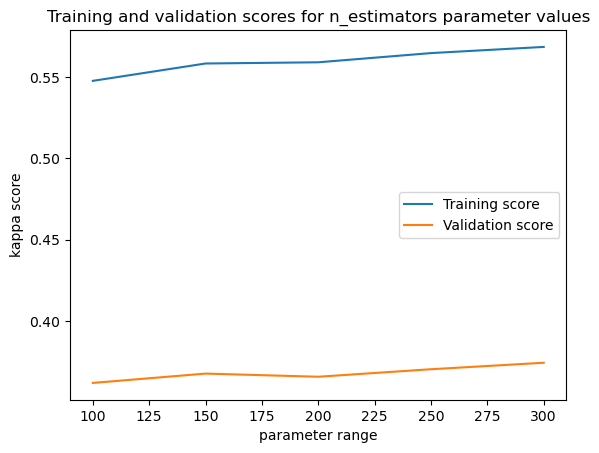

In [46]:
model = RandomForestClassifier(random_state=42, 
                               max_depth=9, 
                               min_samples_split=5, 
                               min_samples_leaf=1, 
                               class_weight='balanced')

param_range=[100, 150, 200, 250, 300]

plot_train_val_scores(model, 'n_estimators', param_range)

So it seems like the scores don't vary too much. The training score seems to go up with higher values though, so to prevent overfitting perhaps n_estimators=150 is indeed the best value. Let's check the max_depth parameter in the same fashion now.

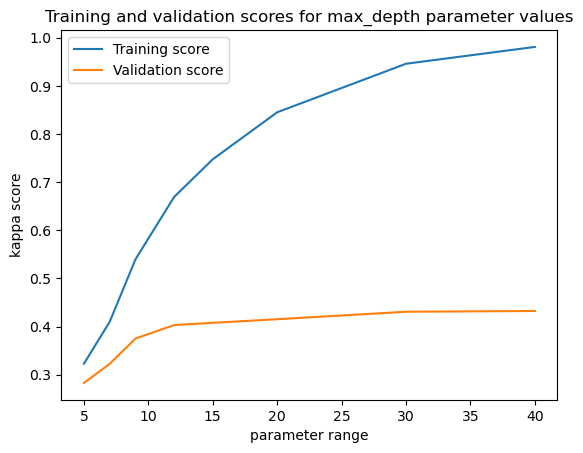

In [47]:
model = RandomForestClassifier(random_state=42, 
                               n_estimators=150, 
                               min_samples_split=5, 
                               min_samples_leaf=1, 
                               class_weight='balanced')

param_range = [5, 7, 9, 12, 15, 20, 30, 40]

plot_train_val_scores(model, 'max_depth', param_range)

This plot shows quite a noticeable difference in the training and validation scores. A max_depth value of around 12 is probably best. Anything more and the training score will be almost 1, which suggests overfitting, and the validation score won't improve much anyways. Anything less, and the validation score will suffer noticeably, suggesting underfitting.

### Evaluation Metrics for Random Forest

Now that we have the best parameters, let's get the relevant scores. First, here is our model.

In [12]:
#so our best model is now the following
random_forest = RandomForestClassifier(
                                       random_state=42, 
                                       n_estimators=150, 
                                       min_samples_split=5, 
                                       min_samples_leaf=1, 
                                       max_depth = 12, 
                                       n_jobs=-1,
                                       class_weight = 'balanced'
                                      )

random_forest.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_split=5, n_estimators=150, n_jobs=-1,
                       random_state=42)

In [13]:
# for comparison table later
rf_best_params = random_forest.get_params()

**Now lets get the accuracy scores.**

In [14]:
training_score_rf = random_forest.score(X, y)
testing_score_rf = random_forest.score(X_test, y_test)

print('Random forest training score:', training_score_rf)
print('Random forest testing score:', testing_score_rf)

Random forest training score: 0.8124040742291057
Random forest testing score: 0.6729441305712492


**Now lets get the kappa scores.**

In [15]:
y_pred = random_forest.predict(X_test)

rf_kappa_training_score = cohen_kappa_score(random_forest.predict(X), y)
rf_kappa_testing_score = cohen_kappa_score(y_pred, y_test)

print('Random forest training score:', rf_kappa_training_score)
print('Random forest testing score:', rf_kappa_testing_score)

Random forest training score: 0.6494821384706173
Random forest testing score: 0.38638465707187375


These scores are better than the initial grid search values, but not better than random forest with the default values (although this was overfitting, so this isn't necessarily a bad thing). It is seeming like this model will not be very good. 

**F1 score.**

In [16]:
y_pred = random_forest.predict(X_test)

f1_weighted_rf = f1_score(y_test, y_pred, average='weighted')

print('The weighted F1 score is:', f1_weighted_rf)

The weighted F1 score is: 0.6692299814489088


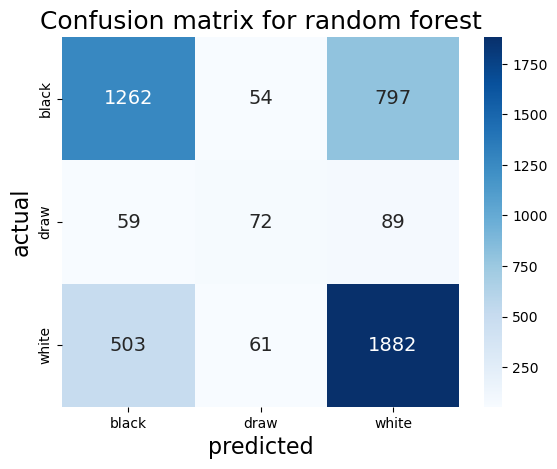

In [57]:
#now let's get the confusion matrix to see how it does
con_mat_rf = confusion_matrix(y_test, y_pred)

sns.heatmap(con_mat_rf, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["black", "draw", "white"], yticklabels = ["black", "draw", "white"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for random forest', fontsize=18)
plt.show()

While you could already start to see that random forest was not as good as logistic regression here, the confusion matrix clearly shows the issue. This model predicts draws almost evenly across each label. Let's take a closer look with roc curves.

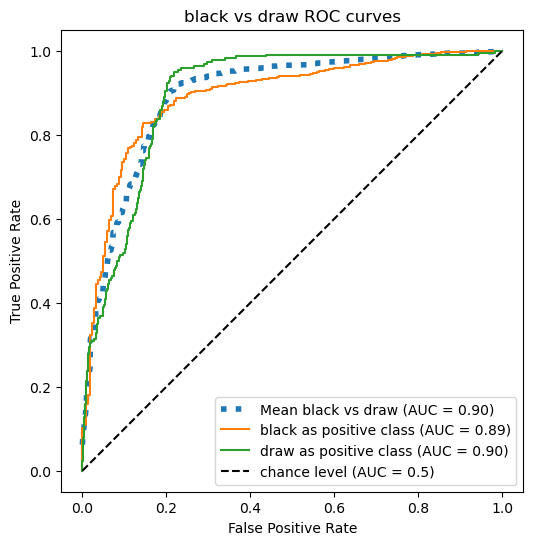

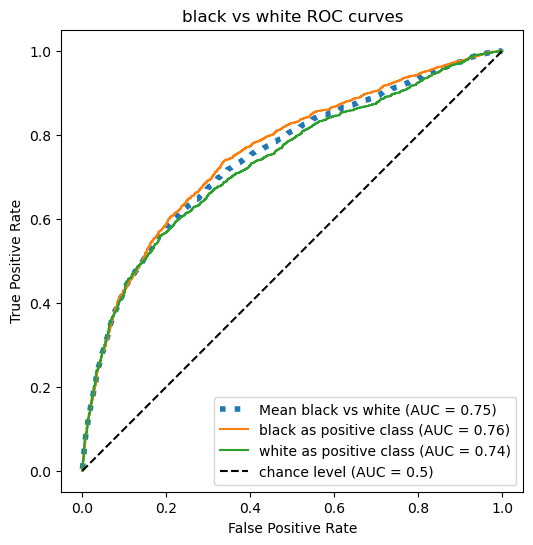

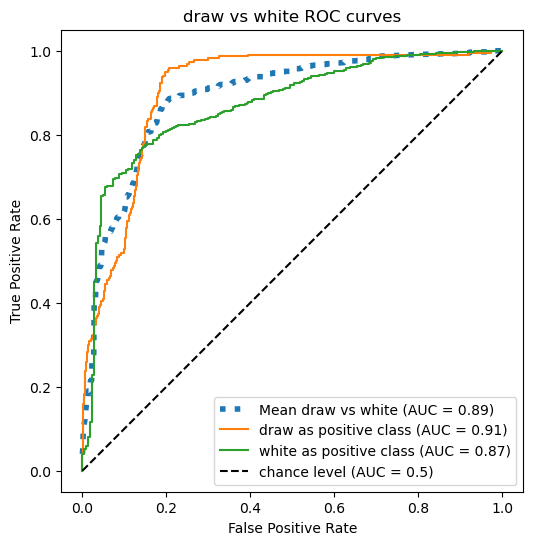

Macro-averaged One-vs-One ROC AUC score:
0.84


In [58]:
roc_curves(random_forest.predict_proba(X_test))

**Some observations about the ROC AUC plots:** The black vs white ROC curves plot is similar to the logistic regression one, but only slightly worse. When looking at the other curves, however, the AUC scores are significantly worse than logistic regression. In both cases where the draw label is the positive class, in order to get a high True positive rate, the False positive rate also needs to be quite high, meaning the model would predict too many games with white or black winners as draws. And then when the draw label is the negative class, both the white and black winner classes have even worse ROC curves and AUC scores. 

The averaged ROC AUC score is 0.84, which is not too bad. But again, the model not being good at predicting draws at all is a problem. Although, if we made a model where we disregarded draws, perhaps it could be useful. Draws are still important though, so we probably won't do this.

## XGboost

First let's try xgboost with the default values. There are a few exceptions, however: tree_method will always be gpu_hist to speed run times up by using a local Nvidia GPU (this is a significant speed up). Objective and num_class are set to indicate this is a multi class problem with 3 classes, and of course n_jobs=-1 is just to use all available CPU cores to also help speed up runtimes (this speed up in general is not as significant).

In [25]:
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', 
                                   num_class=3, 
                                   n_jobs=-1, 
                                   tree_method='gpu_hist', 
                                   random_state=42)

xgb_classifier.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_class=3, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [38]:
print('Accuracy training set score for xgboost with default values:', accuracy_score(y, xgb_classifier.predict(X)))

y_pred = xgb_classifier.predict(X_test)

print('Accuracy testing set score for xgboost with default values:', accuracy_score(y_test,y_pred))

Accuracy training set score for xgboost with default values: 0.9420259522812893
Accuracy testing set score for xgboost with default values: 0.7984934086629002


In [39]:
print('Kappa training set score for xgboost with default values:', cohen_kappa_score(xgb_classifier.predict(X), y))

print('Kappa testing set score for xgboost with default values:', cohen_kappa_score(y_test,y_pred))

Kappa training set score for xgboost with default values: 0.8931084935750433
Kappa testing set score for xgboost with default values: 0.6262299036251138


Now let's try GridSearch with just a few parameters. Unfortunately, run times are too large with this classifier, so we will try some other hyperparameters on their own later, with the validation curve function defined at the beginning of this notebook.

In [13]:
parameters = {
    'learning_rate': [0.1, 0.01, 0.001], 
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 150]
}

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                             num_class=3, 
                             random_state=42, 
                             tree_method='gpu_hist')

clf = GridSearchCV(xgb_clf, parameters, scoring=kappa_scorer, n_jobs=-1)

clf.fit(X, y)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=3,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(cohen_kappa_score))

In [40]:
print('Accuracy training set score for xgboost after GridSearch:', accuracy_score(clf.predict(X), y))

y_pred = clf.predict(X_test)

print('Accuracy testing set score for xgboost after GridSearch:', accuracy_score(y_pred, y_test))

Accuracy training set score for xgboost after GridSearch: 0.8508441467838705
Accuracy testing set score for xgboost after GridSearch: 0.7729650554509312


In [41]:
print('Kappa training set score for xgboost after GridSearch:', clf.score(X, y))

print('Kappa testing set score for xgboost after GridSearch:', clf.score(X_test, y_test))

Kappa training set score for xgboost after GridSearch: 0.7248722216383803
Kappa testing set score for xgboost after GridSearch: 0.579003172812316


So the score actually got worse on all the scores. Seems like the training scores got much worse, while the scores on the testing set only got slightly worse. Now let's see the best parameters that GridSearch found, and use them in a model which we will then test another hyperparameter on. Since all these hyperparameters have their best values as either the largest or smallest in their respective ranges, we can also explore them more closely with larger ranges in that direction.

In [42]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

We'll use the parameters as a starting point. First let's explore the learning rate a bit more.

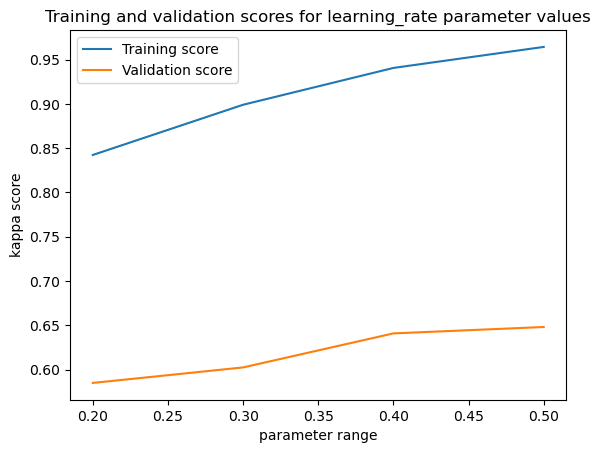

In [52]:
model = xgb.XGBClassifier(objective='multi:softmax', 
                          num_class=3, 
                          random_state=42, 
                          n_jobs=-1, 
                          tree_method='gpu_hist', 
                          max_depth=5, 
                          n_estimators=150)

param_range=[0.2, 0.3, 0.4, 0.5]

plot_train_val_scores(model, 'learning_rate', param_range)

The validation score goes up and levels off at about 0.4, while the training score keeps going up. This means to avoid any overfitting, a learning rate of 0.4 seems to be best. Next, let's look at the max depth parameter more. 

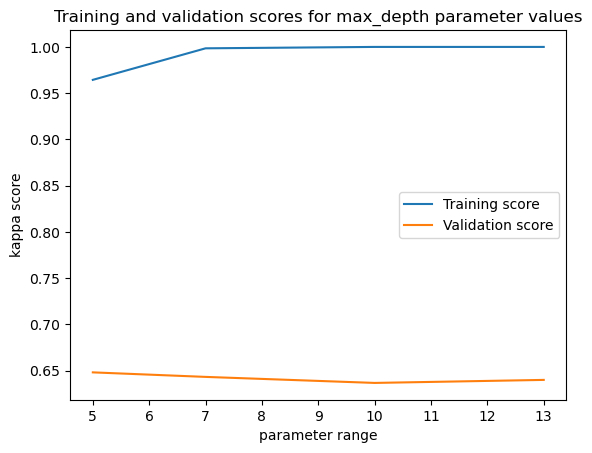

In [48]:
model = xgb.XGBClassifier(objective='multi:softmax', 
                          num_class=3, 
                          random_state=42, 
                          n_jobs=-1, 
                          tree_method='gpu_hist',  
                          n_estimators=150, 
                          learning_rate=0.4)

param_range=[5, 7, 10, 13]

plot_train_val_scores(model, 'max_depth', param_range)

It seems like any max_depth value greater than 5 has no benefit to that validation score, but it does to the training score. This could cause overfitting, so let's stick with 5. Now let's try a new parameter, namely the gamma parameter.

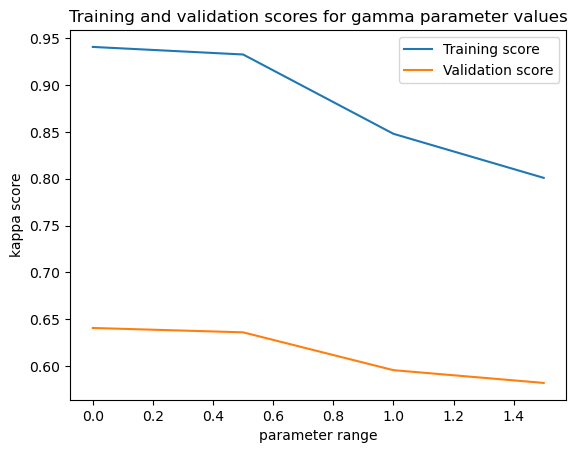

In [53]:
model = xgb.XGBClassifier(objective='multi:softmax', 
                          num_class=3, 
                          random_state=42, 
                          n_jobs=-1, 
                          tree_method='gpu_hist', 
                          max_depth=5, 
                          n_estimators=150, 
                          learning_rate=0.4)

param_range=[0, 0.5, 1, 1.5]

plot_train_val_scores(model, 'gamma', param_range)

It's quite clear that the gamma=0 is probably the best, whic happens to also be the default value. Let's just leave it as is then, and move on to checking other hyperparameters, with the next one being the min_child_weight.

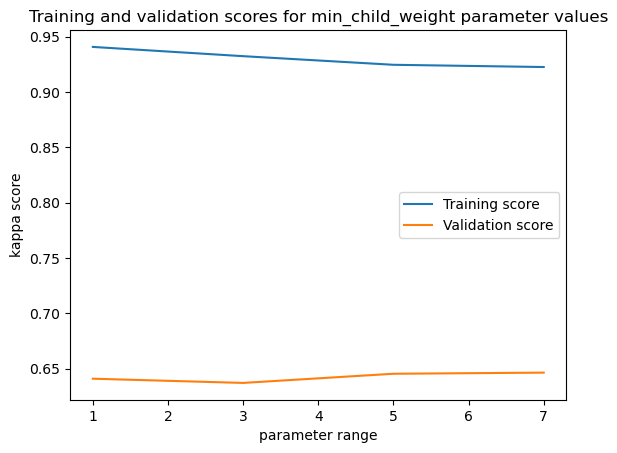

In [54]:
model = xgb.XGBClassifier(objective='multi:softmax', 
                          num_class=3, 
                          random_state=42, 
                          n_jobs=-1, 
                          tree_method='gpu_hist', 
                          max_depth=5, 
                          n_estimators=150, 
                          learning_rate=0.4)

param_range=[1, 3, 5, 7]

plot_train_val_scores(model, 'min_child_weight', param_range)

The min_child_weight seems to have little effect on the kappa score. However, it seems like that for the validation score, which has a very small increase, but for the training score, it actually decreases a little bit. This could reduce overfitting, since the training score is already so high, so let's use the value of 7.

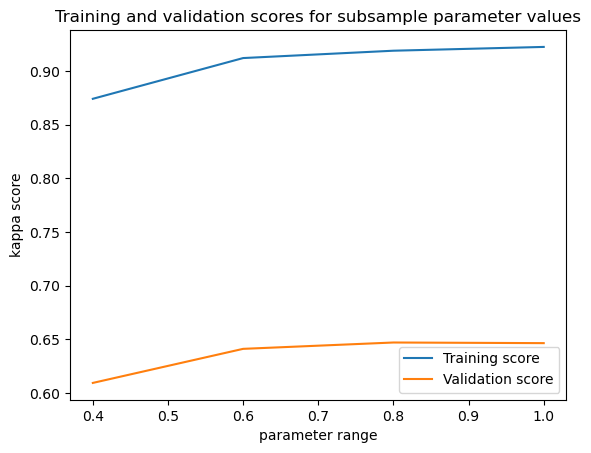

In [9]:
model = xgb.XGBClassifier(objective='multi:softmax', 
                          num_class=3, 
                          random_state=42, 
                          n_jobs=-1, 
                          tree_method='gpu_hist',
                          max_depth=5, 
                          learning_rate=0.4, 
                          n_estimators=150, 
                          min_child_weight=7)

param_range=[0.4, 0.6, 0.8, 1]

plot_train_val_scores(model, "subsample", param_range)

Seems like from this plot that any value above 0.6 doesn't make much of a difference. The default value is 1, so we can leave this as is as well. And with that, we finally have our best model. There are a few more hyperparameters that we could try, but the run times are too high so we will leave it here.

In [17]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                          num_class=3, 
                          random_state=42, 
                          n_jobs=-1, 
                          tree_method='gpu_hist',
                          max_depth=5, 
                          learning_rate=0.4, 
                          n_estimators=150, 
                          min_child_weight=7)

xgb_clf.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_class=3, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [18]:
xgb_best_params = xgb_clf.get_params()

### XGBoost evaluation metrics

Let's get the accuracy, F1, and kappa scores. The kappa scores are of course the more important score, as that is our main metric here. 

In [19]:
training_score_xgb = xgb_clf.score(X, y)
testing_score_xgb = xgb_clf.score(X_test, y_test)

print('XGBoost accuracy training score on final model:', training_score_xgb)

print('XGBoost accuracy testing score on final model:', testing_score_xgb)

XGBoost accuracy training score on final model: 0.9492116645737407
XGBoost accuracy testing score on final model: 0.8254865034526051


In [20]:
training_kappa_xgb = cohen_kappa_score( xgb_clf.predict(X), y)

y_pred = xgb_clf.predict(X_test)

testing_kappa_xgb = cohen_kappa_score(y_pred, y_test)

print('XGBoost kappa training score on final model:', training_kappa_xgb)

print('XGBoost kappa testing score on final model:', testing_kappa_xgb)

XGBoost kappa training score on final model: 0.9063757062789126
XGBoost kappa testing score on final model: 0.676605383995233


In [21]:
f1_weighted_xgb = f1_score(y_test, y_pred, average='weighted')

print('The weighted F1 score for XGBoost is:', f1_weighted_xgb)

The weighted F1 score for XGBoost is: 0.825460690357357


All these scores are pretty good. The kappa testing score may seem like the worst, but it is actually even better than the validation scores from the above plots. The training kappa score is also a bit less, which indicates that with all the training data, there is less indication of overfitting. Perhaps this indicates not enough data. Let's visualize the model performance with the confusion matrix.

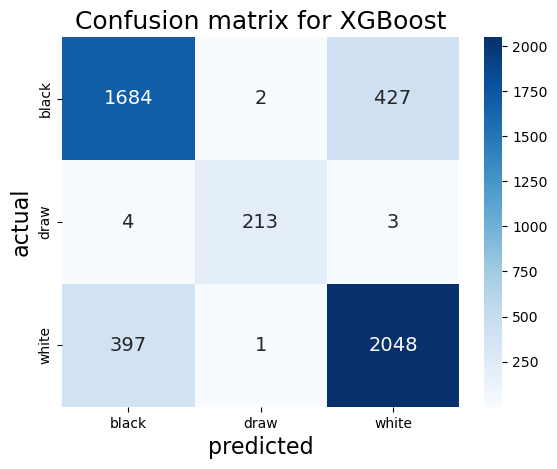

In [28]:
#now let's get the confusion matrix to see how it does
con_mat_rf = confusion_matrix(y_test, y_pred)

sns.heatmap(con_mat_rf, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["black", "draw", "white"], yticklabels = ["black", "draw", "white"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for XGBoost', fontsize=18)
plt.savefig('figures/XGBoost_con_mat.jpg')
plt.show()

This confusion matrix indeed shows that this model is much better than previous ones. It is very good at predicting draws, and doesn't falsely predict black or white as much as the other models. We can also take a quick look at the one vs one roc curves.

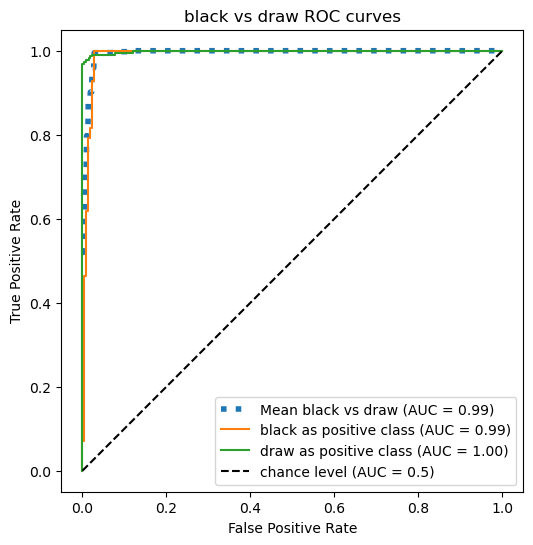

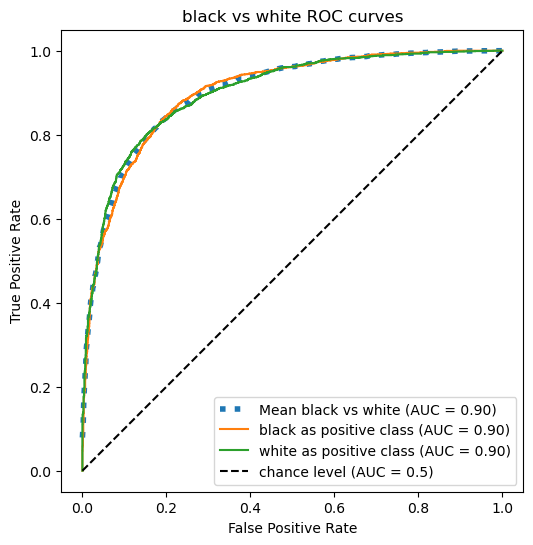

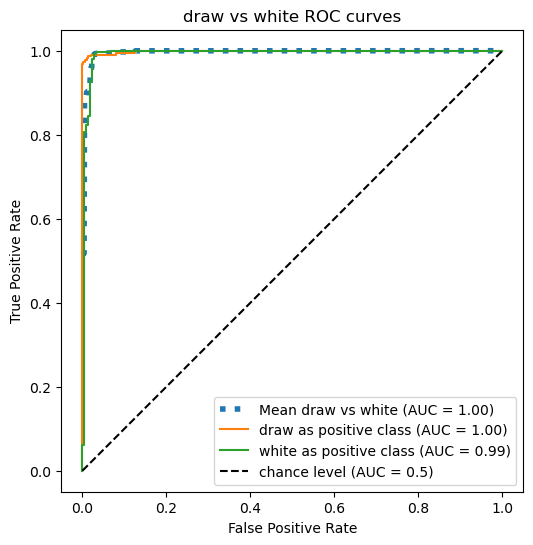

Macro-averaged One-vs-One ROC AUC score:
0.96


In [24]:
roc_curves(xgb_clf.predict_proba(X_test))

As expected from the confusion matrix alone, these roc curves look like the ones from logistic regression but even better. Both plots that compare draws to either color now both have all curves with AUC=>0.99. This of course makes sense since the model is very good at predicting draws correctly, and rarely falsely predicts draws. The black vs white ROC curves have also improved from logistic regression, which is expected since the model doesn't falsely predict either winner as much.

## Comparing all the models

Let's now compare all the metrics of the models ar once.

In [23]:
#getting lists for all the metrics
best_params = [log_reg_best_params, rf_best_params, xgb_best_params]

#we don't really care too much about the f1 score as it isn't our main metric, so we on't include it in the fig below
#f1_weighted = [f1_weighted_lr, f1_weighted_rf, f1_weighted_xgb]

kappa_train_scores = [log_reg_training_kappa, rf_kappa_training_score, training_kappa_xgb]
kappa_test_scores = [log_reg_testing_kappa, rf_kappa_testing_score, testing_kappa_xgb]

In [24]:
#make a dict out of these lists and turn it into a dataframe to easy visualization
metrics_dict = {'best parameters': best_params,
               'kappa training scores': kappa_train_scores, 
               'kappa testing scores': kappa_test_scores}

metrics_df = pd.DataFrame(metrics_dict)

In [25]:
#naming the indices by their respective model names
metrics_df = metrics_df.rename(index={0:'Logistic Regression', 1:'Random Forest', 2:'XGBoost'})

In [32]:
# this will allow the best parameters column to display its entries in full
pd.set_option('display.max_colwidth', None)

metrics_df.to_csv('model_metrics.csv')
metrics_df

,best parameters,kappa training scores,kappa testing scores
Logistic Regression,"{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 25, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",0.666293,0.557663
Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}",0.649482,0.386385
XGBoost,"{'objective': 'multi:softmax', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.4, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None, 'num_class': 3}",0.906376,0.676605


These scores are pretty easy to analyze, because you must simply observe that the XGBoost model has the best score for all metrics. The logistic regression and random forest model have some scores that are close, but still some where logistic regression is clearly better. The F1 scores don't show anything suspicious, and follow in line with the accuracy and kappa scores.

In any case, the XGBoost model has a kappa test score of about 0.68, which is in the substantial range, as mentioned by the reference in the beginning of the notebook. This means it is a good model. Definitely room for improvement though, but run times are quite significant with XGBoost. **Thus, the XGBoost model is the best model.**

### A note about feature reduction using Truncated SVD

On an earlier trial run, the truncated svd function was used to reduce the number of features, since there are more than a few thousand columns as it stands. You can see below that this did not work. Run times were to high to retry this again with the final model, but the point is that PCA is not meant to be used for one-hot encoded and text classification problems, but rather truncated svd is. That being said, reducing the number of features harmed the model, so feature reduction doesn't seem to be useful in this problem. 

It turns out that feature reduction methods like this in text classification problems tends to make models. See here: https://stats.stackexchange.com/questions/52773/what-can-cause-pca-to-worsen-results-of-a-classifier. 

In [78]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=600)
svd.fit(X)

TruncatedSVD(n_components=600)

In [80]:
sum(sorted(svd.explained_variance_ratio_, reverse=True))

0.948524888390113

In [81]:
X_svd = svd.transform(X)

In [82]:
X_svd_df = pd.DataFrame(data=X_svd)

In [62]:
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', 
                                   num_class=3, 
                                   n_jobs=-1, 
                                   tree_method='gpu_hist', 
                                   random_state=42)

xgb_classifier.fit(X_svd_df,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_class=3, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [63]:
xgb_classifier.score(X_svd_df,y)

0.9998604716059718

In [64]:
y_pred_pca = xgb_classifier.predict(X_svd_df)

In [65]:
cohen_kappa_score(y_pred_pca, y)

0.9997428787651493

In [66]:
X_test_svd = svd.transform(X_test)

X_test_svd_df = pd.DataFrame(data=X_test_svd)

In [67]:
y_pred_svd_test = xgb_classifier.predict(X_test_svd_df)

In [68]:
cohen_kappa_score(y_pred_svd_test, y_test)

0.4257910433334474

In [73]:
parameters = {
    'learning_rate': [0.1, 0.01], 
    'max_depth': [3, 4, 5], 
    'gamma': [0, 0.1, 0.5, 1, 2], 
    'n_estimators': [50, 100, 150], 
    'subsample': [0.4, 0.5, 0.6, 0.9, 1]
}

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                             num_class=3, 
                             random_state=42, 
                             tree_method='gpu_hist')

clf = GridSearchCV(xgb_clf, parameters, scoring=kappa_scorer, n_jobs=-1)

clf.fit(X_svd_df, y)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=3,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.5, 1, 2],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.4, 0.5, 0.6, 0.9, 1]},
             scoring=make_scorer(cohen_kappa_score))

In [83]:
clf.score(X_svd_df, y)

0.6234759094974137

In [84]:
clf.score(X_test_svd_df, y_test)

0.4482197422445199